In [1]:
import ismrmrd
import rtoml
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import ifftshift
import mrdhelper

# Read config
with open('config.toml', 'r') as cf:
    cfg = rtoml.load(cf)

DATA_ROOT = cfg['DATA_ROOT']
DATA_DIR = cfg['data_folder']
raw_file = cfg['raw_file']
remove_os = cfg['saving']['remove_os']

ismrmrd_data_fullpath, _ = mrdhelper.siemens_mrd_finder(DATA_ROOT, DATA_DIR, raw_file)

In [2]:
# Read the data in
print(f'Reading {ismrmrd_data_fullpath}...')
with ismrmrd.Dataset(ismrmrd_data_fullpath) as dset:

    n_acq = dset.number_of_acquisitions()
    print(f'There are {n_acq} acquisitions in the file. Reading...')

    acq_list = []
    for ii in range(n_acq):
        acq_list.append(dset.read_acquisition(ii))

    n_wf = dset.number_of_waveforms()
    print(f'There are {n_wf} waveforms in the dataset. Reading...')

    wf_list = []
    for ii in range(n_wf):
        wf_list.append(dset.read_waveform(ii))
    
    hdr = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

# get the k-space trajectory based on the metadata hash.
traj_name = hdr.userParameters.userParameterString[1].value

# load the .mat file containing the trajectory
traj = loadmat(os.path.join(DATA_ROOT, DATA_DIR, traj_name), squeeze_me=True)

n_unique_angles = int(traj['param']['repetitions'])

kx = traj['kx'][:,:]
ky = traj['ky'][:,:]
dt = float(traj['param']['dt'])
msize = int(10 * traj['param']['fov'] / traj['param']['spatial_resolution'])
pre_discard = int(traj['param']['pre_discard'])
w = traj['w']

# Convert raw data and trajectory into convenient arrays
ktraj = np.stack((kx, -ky), axis=2)
# find max ktraj value
kmax = np.max(np.abs(kx + 1j * ky))
# swap 0 and 1 axes to make repetitions the first axis (repetitions, interleaves, 2)
ktraj = np.swapaxes(ktraj, 0, 1)
ktraj = 0.5 * (ktraj / kmax) * msize

data = [arm.data[:,:] for arm in acq_list]
dcf = np.tile(w[None, :], (n_acq, 1))
coord = [ktraj[ii%n_unique_angles,:,:] for ii in range(n_acq)]

data = np.array(data)
data = np.transpose(data, axes=(2, 0, 1))
coord = np.array(coord, dtype=np.float32)
coord = np.transpose(coord, axes=(2, 1, 0))


Reading /server/home/btasdelen/MRI_DATA/pilottone/vol0912_20240626/raw/h5/meas_MID00287_FID16396_pulseq2D_fire_spiralga_400mV_24MHz.h5...
There are 14400 acquisitions in the file. Reading...
There are 4431 waveforms in the dataset. Reading...


Coils to be used as sniffers: ['Spine_18:1:S4T' 'Spine_18:1:S4S' 'Spine_18:1:S4P']


/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


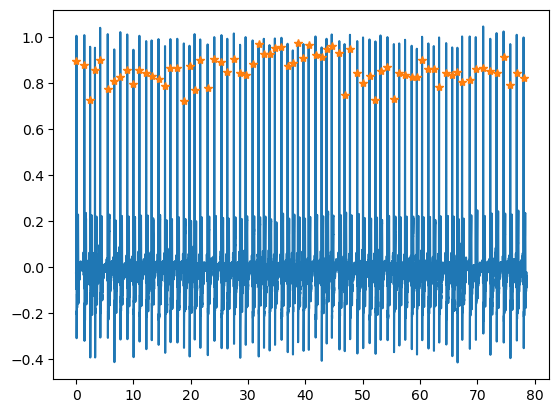

In [3]:
mri_coils = np.arange(15, dtype=int)
sensing_coils = np.array([15, 16, 17], dtype=int)
coil_name = []

for clbl in hdr.acquisitionSystemInformation.coilLabel:
    coil_name.append(clbl.coilName)

coil_name = np.asarray(coil_name)

print(f"Coils to be used as sniffers: {coil_name[sensing_coils.astype(int)]}")

f0 = hdr.experimentalConditions.H1resonanceFrequency_Hz
df = 1/(dt*data.shape[0])

t_acq_start = acq_list[0].acquisition_time_stamp*2.5e-3 # [2.5ms] -> [s]
t_acq_end = acq_list[-1].acquisition_time_stamp*2.5e-3
time_acq = np.linspace(t_acq_start, t_acq_end, n_acq) # Interpolate for TR, as TR will not be a multiple of time resolution.
time_pt = time_acq - t_acq_start
samp_time_pt = time_acq[1] - time_acq[0]

ksp_measured = data[:,:,mri_coils]
ksp_sniffer  = data[:,:,sensing_coils]

## Process ECG waveform
ecg_waveform = []
ecg_trigs = []
wf_init_timestamp = 0
for wf in wf_list:
    if wf.getHead().waveform_id == 0:
        ecg_waveform.append(wf.data[0,:])
        ecg_trigs.append(wf.data[4,:])
        if wf_init_timestamp == 0:
            wf_init_timestamp = wf.time_stamp
            ecg_sampling_time = wf_list[0].getHead().sample_time_us*1e-6 # [us] -> [s]

ecg_waveform = (np.asarray(np.concatenate(ecg_waveform, axis=0), dtype=float)-2048)
ecg_waveform = ecg_waveform/np.percentile(ecg_waveform, 99.9)
ecg_trigs = (np.concatenate(ecg_trigs, axis=0)/2**14).astype(int)
time_ecg = np.arange(ecg_waveform.shape[0])*ecg_sampling_time - (acq_list[0].acquisition_time_stamp - wf_init_timestamp)*1e-3
plt.figure()
plt.plot(time_ecg, ecg_waveform)
plt.plot(time_ecg[ecg_trigs==1], ecg_waveform[ecg_trigs==1], '*')

## PT correction

/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


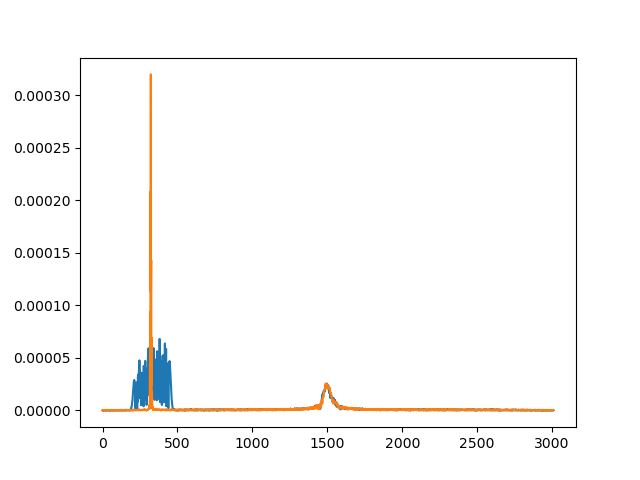

In [4]:
%matplotlib widget
import pilottone as pt
import importlib

f_pt = 24e6 # [Hz]
f_diff = f0 - f_pt

# ================================
# Demodulate any shifts
# ================================
phase_mod_rads = pt.calc_fovshift_phase(
    np.vstack((np.zeros((pre_discard, n_unique_angles)), kx)), 
    np.vstack((np.zeros((pre_discard, n_unique_angles)), ky)), 
    acq_list[0])
phase_mod_rads = [phase_mod_rads[:,ii%n_unique_angles] for ii in range(n_acq)]
phase_mod_rads = np.array(phase_mod_rads)[:, :].transpose()[:,:,None]

# Apply the negative of the phase
ksp_sniffer_  = ksp_sniffer*phase_mod_rads
ksp_measured_ = ksp_measured*phase_mod_rads

plt.figure()
plt.plot(np.abs(pt.signal.to_hybrid_kspace(ksp_measured[:,10,0])))
plt.plot(np.abs(pt.signal.to_hybrid_kspace(ksp_measured_[:,10,0])))
plt.show()



8.651060104370117


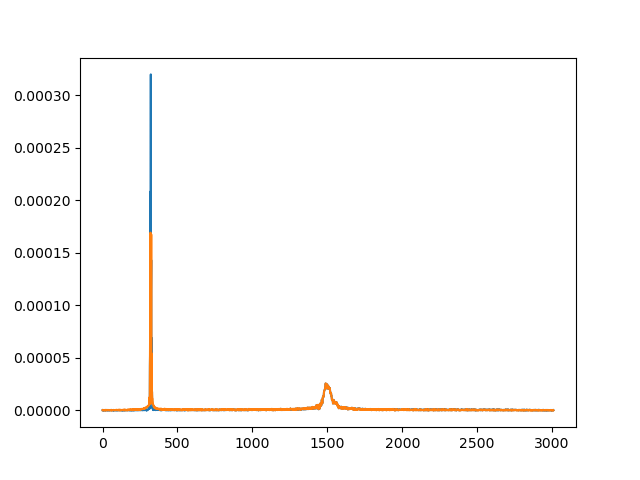

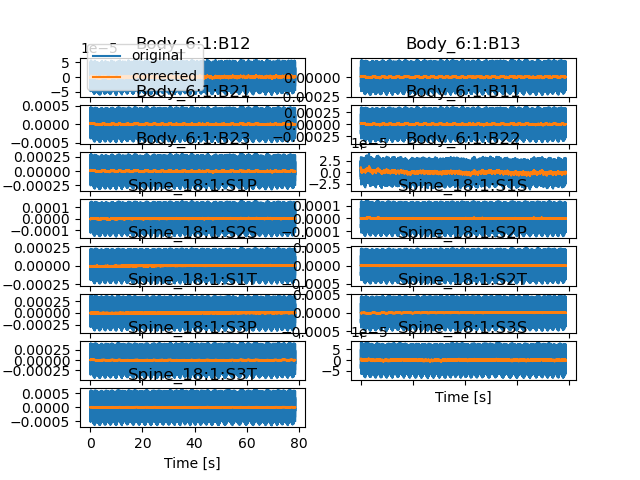

In [5]:
importlib.reload(pt)

fcorrmin = pt.find_freq_qifft(ksp_measured_[:,:,:], df, f_diff, 3e3, 4, (2))

ksp_window = np.ones(ksp_measured_.shape[0])
# ksp_window = ksp_window[nc:]
ksp_measured_ = ksp_measured_*ksp_window[:,None,None]
ksp_sniffer_ = ksp_sniffer_*ksp_window[:,None,None]

time_acq = np.arange(0, ksp_measured_.shape[0])*dt

ksp_ptsubbed_, pt_sig_fit = pt.est_dtft(time_acq, ksp_measured_, np.array([f_diff])-fcorrmin, ksp_window)
_, pt_sig_fit_sniffer = pt.est_dtft(time_acq, ksp_sniffer_, np.array([f_diff])-fcorrmin, ksp_window)

pt_sig_fit = np.abs(pt_sig_fit)
pt_sig_fit_sniffer = np.abs(pt_sig_fit_sniffer)
pt_sig = np.squeeze(pt_sig_fit - np.mean(pt_sig_fit, axis=1, keepdims=True))
pt_sig_sniffer = np.squeeze(pt_sig_fit_sniffer - np.mean(pt_sig_fit_sniffer, axis=1, keepdims=True))

plt.figure()
plt.plot(np.abs(pt.signal.to_hybrid_kspace(ksp_measured_[:,10,0])))
plt.plot(np.abs(pt.signal.to_hybrid_kspace(ksp_ptsubbed_[:,10,0])))
plt.show()

# Pilot tone cleanup?
pt_sig_clean = pt.sniffer_sub(pt_sig, pt_sig_sniffer)

pt.plot_multich_comparison(time_pt, (pt_sig, pt_sig_clean), coil_name[mri_coils], ('original', 'corrected'))



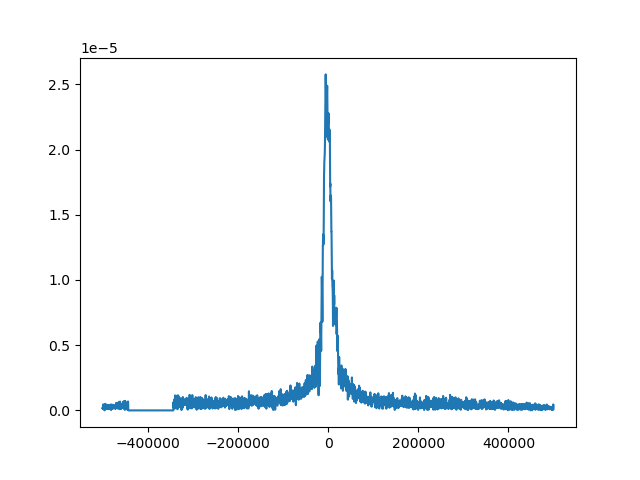

In [6]:
# Filter a bandwidth around the pilot tone frequency.
fbw = 100e3
freq_axis = ifftshift(np.fft.fftfreq(ksp_ptsubbed_.shape[0], dt))

ptmdlflt = np.ones((ksp_ptsubbed_.shape[0]))
ptmdlflt[(freq_axis < (f_diff+fbw/2)) & (freq_axis > (f_diff-fbw/2))] = 0
ksp_ptsubbed_ = pt.signal.from_hybrid_kspace(ptmdlflt[:,None,None]*pt.signal.to_hybrid_kspace(ksp_ptsubbed_))

plt.figure()
plt.plot(freq_axis, np.abs(pt.signal.to_hybrid_kspace(ksp_ptsubbed_[:,10,0])))
plt.show()

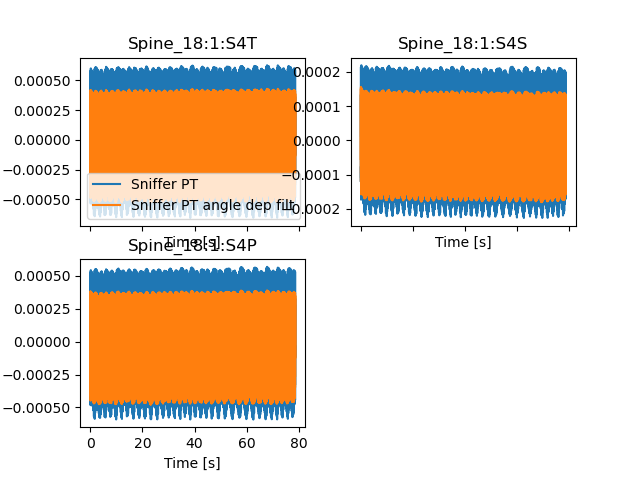

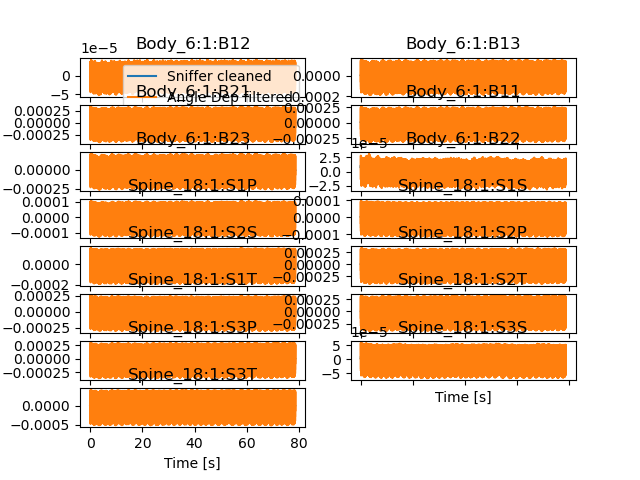

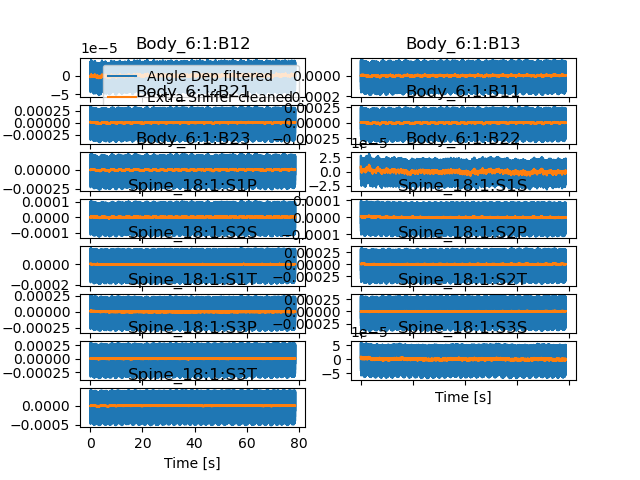

In [7]:
import numpy.typing as npt

def angle_dependant_filtering(sig: npt.NDArray[np.float64], n_unique_angles: int, angle_step:float=222.4922, pdegree:int=9) -> npt.NDArray[np.float64]:
    n_acq, nc = sig.shape[0:2]
    nrep = n_acq//n_unique_angles 
    angs = np.arange(n_unique_angles)*angle_step % 360
    angs_sorted = np.sort(angs)
    angles = np.tile(angs, (nrep,))
    I_angles = np.argsort(angles)
    Irev = np.argsort(I_angles)
    # plt.figure()
    # plt.plot(angles[I], sig[I, 4], '.')
    # plt.show()
    pt_sig_mean = np.mean(sig[I_angles,:].reshape((n_unique_angles, nrep, nc)), axis=1)

    # plt.figure()
    # plt.plot(pt_sig_mean, '.')
    # plt.show()

    from numpy.polynomial import Polynomial
    sig_filtered = np.zeros(sig.shape)
    for chi in range(nc):
        p = Polynomial.fit(angs_sorted, pt_sig_mean[:,chi], deg=pdegree)
        # xx, yy = p.linspace()
        # plt.figure()
        # plt.plot(np.sort(angs), pt_sig_mean[:,0], '.')
        # plt.plot(np.sort(angs), p(np.sort(angs)), '-')
        # plt.show()

        sig_filtered[:,chi] = (sig[I_angles, chi] - p(angles[I_angles]))[Irev]


    # plt.figure()
    # plt.plot(p(angles[I])[Irev], '*')
    return sig_filtered

pt_sig_clean2 = angle_dependant_filtering(pt_sig, n_unique_angles)
pt_sig_sniffer_clean2 = angle_dependant_filtering(pt_sig_sniffer, n_unique_angles)

pt.plot_multich_comparison(time_pt, (pt_sig_sniffer, pt_sig_sniffer_clean2), coil_name[sensing_coils], ('Sniffer PT','Sniffer PT angle dep filt'))
pt.plot_multich_comparison(time_pt, (pt_sig_clean, pt_sig_clean2), coil_name[mri_coils], ('Sniffer cleaned', 'Angle Dep filtered'))

pt_sig_clean3 = pt.sniffer_sub(pt_sig_clean2, pt_sig_sniffer_clean2)
pt.plot_multich_comparison(time_pt, (pt_sig_clean2, pt_sig_clean3), coil_name[mri_coils], ('Angle Dep filtered', 'Extra Sniffer cleaned'))


/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


0: 0.058811569677879594
1: 0.022136843765206034
2: 0.015220286004331717
3: 0.014928882444077375
4: 0.0149090418653139
5: 0.014911132454572892
6: 0.01491088705136662
7: 0.014910891526704316
8: 0.014910891131848654
9: 0.014910881786752676
10: 0.01491088287680951
11: 0.01491088215457927
12: 0.014910881325380071
13: 0.014910881095410918
14: 0.01491088111968032
15: 0.014910881189696261
16: 0.014910881189300635
17: 0.0149108811891562
18: 0.014910881189098325
19: 0.014910881189072168
20: 0.01491088118905494
21: 0.014910881189036267
Extracted voltage: 0.4 V
SG filter length = 107.


Text(0.5, 0.98, 'Extracted PT navigators')

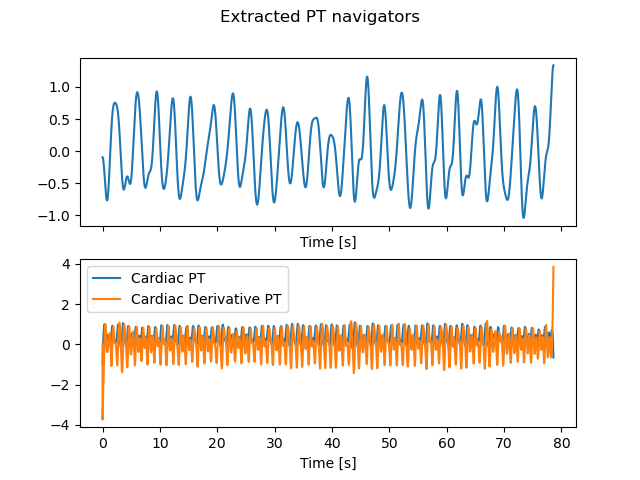

In [8]:
%matplotlib widget
importlib.reload(pt)

f_samp = 1/samp_time_pt # [Hz]
pt_extract_params = {'golay_filter_len': 81,
                   'respiratory': {
                           'freq_start': 0.05,
                           'freq_stop': 0.9,
                           'corr_threshold': 0.9,
                           'corr_init_ch': -1,
                           'separation_method': 'sobi', # 'sobi', 'pca'
                   },
                   'cardiac': {
                            'freq_start': 1,
                            'freq_stop': 20,
                            'corr_threshold': 0.90,
                            'corr_init_ch': np.nonzero(coil_name == 'Body_6:1:B22')[0][0],                           
                            'separation_method': 'pca', # 'sobi', 'pca'

                   },
                   'debug': {
                       'selected_coils': [0,1],
                       'coil_legend': coil_name[mri_coils],
                       'show_plots': False
                   }
                }

    
pt_respiratory, pt_cardiac = pt.extract_pilottone_navs(pt_sig_clean2, f_samp, pt_extract_params)

from scipy.signal import savgol_filter
pt_volt = pt.get_volt_from_protoname(hdr.measurementInformation.protocolName)
if pt_volt is not None:
    print(f"Extracted voltage: {pt_volt} V")
    sg_filter_len = int(np.round((-18.37*np.log(pt_volt)+88.87)/2)*2+1) # Empirically found.
else:
    sg_filter_len = 91

print(f'SG filter length = {sg_filter_len}.')
pt_cardiac_filtered = savgol_filter(pt_cardiac, sg_filter_len, 3, axis=0)
pt_cardiac_derivative = np.hstack((0, -np.diff(pt_cardiac_filtered)/(time_pt[1] - time_pt[0])))
pt_cardiac_derivative /= np.percentile(pt_cardiac_derivative, 99)

ff, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(time_pt, pt_respiratory, label='Respiratory PT')
axs[1].plot(time_pt, pt_cardiac, label='Cardiac PT')
axs[1].plot(time_pt, pt_cardiac_derivative, label='Cardiac Derivative PT')
axs[1].legend()
axs[0].set_xlabel('Time [s]')
axs[1].set_xlabel('Time [s]')
plt.suptitle('Extracted PT navigators')

In [9]:
# import scipy as sp
# respnav_im = np.load('output_recons/vol0902_20240611/respnav_meas_MID00175_FID15580_pulseq2D_fire_spiralga_400mV_24MHz_editer.npy')
# # respnav_im = sp.signal.detrend(respnav_im)

# narms = 17
# navdt = narms*samp_time_pt
# time_rnav = np.arange(respnav_im.shape[0])*navdt + navdt/2
# # model = np.polyfit(time_rnav, respnav_im, 11)
# # predicted = np.polyval(model, time_rnav)
# # respnav_im -= predicted
# respnav_im -= np.mean(respnav_im)
# plt.figure()
# plt.plot(time_pt, -pt_respiratory, label='Pilot Tone Navigator')
# plt.plot(time_rnav, (respnav_im/np.percentile(respnav_im, 95))-0.1, label='Image Navigator')
# plt.legend()
# plt.show()



## QA and ECG PT Jitter

Rejection ratio for pt peaks is 2.70 percent.

Rejection ratio for derivative pt peaks is 0.00 percent.

Peak difference 280.9 ± 17.8
Derivative peak difference 448.9 ± 14.0
Number of ECG triggers: 73.
Number of PT triggers: 74.
Number of missed PT triggers: 0.
Number of extraneous PT triggers: 1.
Number of derivative PT triggers: 84.
Number of missed derivative PT triggers: 0.
Number of extraneous derivative PT triggers: 11.


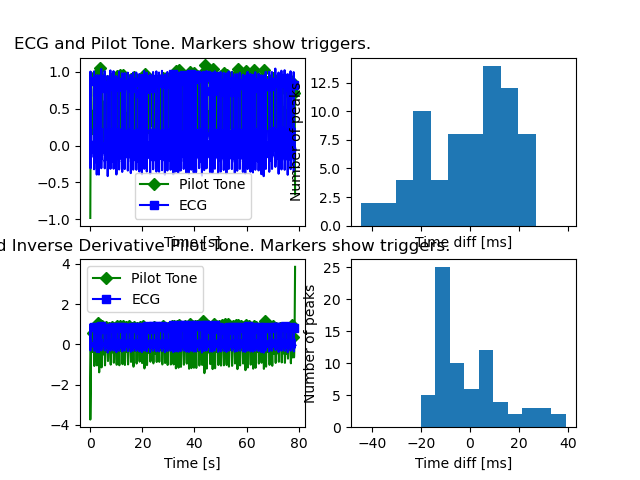

In [10]:
from scipy.signal import find_peaks
from pilottone.pt import beat_rejection, interval_peak_matching

%matplotlib widget

skip_time = 0.6 # [s]

# ECG Triggers
# ecg_peak_locs,_ = find_peaks(ecg_waveform[time_ecg > skip_time], prominence=0.7)
ecg_peak_locs = np.nonzero(ecg_trigs[time_ecg > skip_time])[0]
ecg_peak_locs += np.sum(time_ecg <= skip_time)

# PT Triggers
dt_pt = (time_pt[1] - time_pt[0])
Dmin = int(np.ceil(0.6/(dt_pt))) # Min distance between two peaks, should not be less than 0.6 secs (100 bpm max assumed)
pt_cardiac_peak_locs,_ = find_peaks(pt_cardiac[time_pt > skip_time], prominence=0.4, distance=Dmin)
pt_cardiac_peak_locs += np.sum(time_pt <= skip_time)

# PT Derivative Triggers
pt_cardiac_derivative_peak_locs,_ = find_peaks(pt_cardiac_derivative[time_pt > skip_time], prominence=0.6, distance=Dmin)
pt_cardiac_derivative_peak_locs += np.sum(time_pt <= skip_time)

# "Arryhtmia detection" by heart rate variation
hr_accept_list = beat_rejection(pt_cardiac_peak_locs*dt_pt, "post")
hr_accept_list_derivative = beat_rejection(pt_cardiac_derivative_peak_locs*dt_pt, "pre")
# TODO: Is pre post even correct? Why does it change? Need to investigate.
print(f'Rejection ratio for pt peaks is {100*(len(hr_accept_list) - np.sum(hr_accept_list))/len(hr_accept_list):.2f} percent.\n')
print(f'Rejection ratio for derivative pt peaks is {100*(len(hr_accept_list_derivative) - np.sum(hr_accept_list_derivative))/len(hr_accept_list_derivative):.2f} percent.\n')


# peak_diff, pt_peaks_selected = prepeak_matching(time_pt, pt_cardiac_peak_locs, time_ecg, ecg_peak_locs)
# derivative_peak_diff, pt_derivative_peaks_selected = prepeak_matching(time_pt, pt_cardiac_derivative_peak_locs, time_ecg, ecg_peak_locs)

peak_diff, miss_pks, extra_pks = interval_peak_matching(time_pt, pt_cardiac_peak_locs, time_ecg, ecg_peak_locs)
pt_peaks_selected = pt_cardiac_peak_locs

derivative_peak_diff, derivative_miss_pks, derivative_extra_pks = interval_peak_matching(time_pt, pt_cardiac_derivative_peak_locs, time_ecg, ecg_peak_locs)
pt_derivative_peaks_selected = pt_cardiac_derivative_peak_locs

# Create trigger waveforms from peak locations.
pt_cardiac_trigs = np.zeros((n_acq,), dtype=np.uint32)
pt_derivative_trigs = np.zeros((n_acq,), dtype=np.uint32)
pt_cardiac_trigs[pt_peaks_selected] = 1
pt_derivative_trigs[pt_derivative_peaks_selected] = 1

# Print some useful info

print(f'Peak difference {np.mean(peak_diff*1e3):.1f} \u00B1 {np.std(peak_diff*1e3):.1f}')
print(f'Derivative peak difference {np.mean(derivative_peak_diff*1e3):.1f} \u00B1 {np.std(derivative_peak_diff*1e3):.1f}')

print(f'Number of ECG triggers: {ecg_peak_locs.shape[0]}.')
print(f'Number of PT triggers: {pt_cardiac_peak_locs.shape[0]}.')
print(f'Number of missed PT triggers: {miss_pks.shape[0]}.')
print(f'Number of extraneous PT triggers: {extra_pks.shape[0]}.')
print(f'Number of derivative PT triggers: {pt_cardiac_derivative_peak_locs.shape[0]}.')
print(f'Number of missed derivative PT triggers: {derivative_miss_pks.shape[0]}.')
print(f'Number of extraneous derivative PT triggers: {derivative_extra_pks.shape[0]}.')


# Plots
f, axs = plt.subplots(2,2, sharex='col')
axs[0,0].plot(time_pt, pt_cardiac, '-gD', markevery=pt_cardiac_peak_locs, label='Pilot Tone')
axs[0,0].plot(time_ecg, ecg_waveform, '-bs', markevery=ecg_peak_locs, label='ECG')
axs[0,0].set_xlabel('Time [s]')
axs[0,0].legend()
axs[0,0].set_title('ECG and Pilot Tone. Markers show triggers.')

axs[0,1].hist((peak_diff - np.mean(peak_diff))*1e3)
axs[0,1].set_xlabel('Time diff [ms]')
axs[0,1].set_ylabel('Number of peaks')

axs[1,0].plot(time_pt, pt_cardiac_derivative, '-gD', markevery=pt_cardiac_derivative_peak_locs, label='Pilot Tone')
axs[1,0].plot(time_ecg, ecg_waveform, '-bs', markevery=ecg_peak_locs, label='ECG')
axs[1,0].set_xlabel('Time [s]')
axs[1,0].legend()
axs[1,0].set_title('ECG and Inverse Derivative Pilot Tone. Markers show triggers.')

axs[1,1].hist((derivative_peak_diff - np.mean(derivative_peak_diff))*1e3)
axs[1,1].set_xlabel('Time diff [ms]')
axs[1,1].set_ylabel('Number of peaks')

plt.show()


## Save the waveforms into the original data

In [11]:
# Concat, and normalize pt waveforms.
import ctypes
pt_wf_data = np.vstack((pt_respiratory, pt_cardiac, pt_cardiac_trigs, pt_cardiac_derivative, pt_derivative_trigs))
pt_wf_data = ((pt_wf_data/np.max(np.abs(pt_wf_data), axis=1, keepdims=True)*(2**31-1)) + 2**31).astype(np.uint32)

pt_wf = ismrmrd.waveform.Waveform.from_array(pt_wf_data)
pt_wf._head.sample_time_us = ctypes.c_float(dt_pt*1e6)
pt_wf._head.waveform_id = ctypes.c_uint16(1025)
pt_wf._head.time_stamp = acq_list[0].acquisition_time_stamp

with ismrmrd.Dataset(ismrmrd_data_fullpath) as dset:
    dset.append_waveform(pt_wf)

print('Done writing the waveform.')


Done writing the waveform.


# Save the PT subtracted k-space

In [12]:

if cfg['saving']['save_model_subtracted']:
    from pathlib import Path
    import copy
    import pyfftw

    ksp_ptsubbed = ksp_ptsubbed_*np.conj(phase_mod_rads)

    n_samp = ksp_ptsubbed.shape[0]

    if remove_os:
        ksp_ptsubbed = pyfftw.byte_align(ksp_ptsubbed)

        keepOS = np.concatenate([np.arange(n_samp // 4), np.arange(n_samp * 3 // 4, n_samp)])
        ifft_ = pyfftw.builders.ifft(ksp_ptsubbed, n=n_samp, axis=0, threads=32, planner_effort='FFTW_ESTIMATE')
        ksp_ptsubbed = ifft_()

        fft_ = pyfftw.builders.fft(ksp_ptsubbed[keepOS, :, :], n=keepOS.shape[0], axis=0, threads=32, planner_effort='FFTW_ESTIMATE')
        ksp_ptsubbed = fft_()
        n_samp = n_samp // 2


    output_dir_fullpath = os.path.join(DATA_ROOT, DATA_DIR, 'raw', 'h5_proc')
    output_data_fullpath = os.path.join(output_dir_fullpath, f'{ismrmrd_data_fullpath.split('/')[-1][:-3]}_mdlsub.h5')
    print('Saving to ' + output_data_fullpath)

    Path.mkdir(Path(output_dir_fullpath), exist_ok=True)

    # Add EDITER parameters to XML header.
    new_hdr = copy.deepcopy(hdr)
    new_hdr.userParameters.userParameterString.append(ismrmrd.xsd.userParameterStringType('processing', 'ModelSubtraction'))
    new_hdr.acquisitionSystemInformation.coilLabel = [hdr.acquisitionSystemInformation.coilLabel[ch_i] for ch_i in mri_coils]
    new_hdr.acquisitionSystemInformation.receiverChannels = len(new_hdr.acquisitionSystemInformation.coilLabel)

    # Copy and fix acquisition objects
    new_acq_list = []

    for acq_i, acq_ in enumerate(acq_list):
        new_head = copy.deepcopy(acq_.getHead())
        new_head.active_channels = len(new_hdr.acquisitionSystemInformation.coilLabel)
        new_head.available_channels = len(new_hdr.acquisitionSystemInformation.coilLabel)
        if remove_os:
            new_head.number_of_samples = ksp_ptsubbed.shape[0]
            new_head.center_sample = pre_discard//2

        new_acq_list.append(ismrmrd.Acquisition(head=new_head, data=np.ascontiguousarray(ksp_ptsubbed[:,acq_i,:].squeeze().T.astype(np.complex64))))

    with ismrmrd.Dataset(output_data_fullpath, create_if_needed=True) as new_dset:
        for acq_ in new_acq_list:
            new_dset.append_acquisition(acq_)

        for wave_ in wf_list:
            new_dset.append_waveform(wave_)

        new_dset.append_waveform(pt_wf)

        new_dset.write_xml_header(ismrmrd.xsd.ToXML(new_hdr))

Saving to /server/home/btasdelen/MRI_DATA/pilottone/vol0912_20240626/raw/h5_proc/meas_MID00287_FID16396_pulseq2D_fire_spiralga_400mV_24MHz_mdlsub.h5


/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/h5py/_hl/filters.py:250: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  chunks = guess_chunk(shape, maxshape, dtype.itemsize)
